# Evaluating performance of the WiFi network 

## 1. Find the interface and IP of the wireless connection

Command: ip route get 8.8.8.8

Example output: 8.8.8.8 via 192.168.0.1 dev **wlp0s20f3** src **192.168.0.4** uid 1000 
    cache 

In [24]:
import subprocess
import re

def send_cmd(cmd):
    result = subprocess.run(cmd,capture_output=True, text=True, check=True)
    return result

def find_wifi_interface(): 
    result = send_cmd(['ip','route','get','8.8.8.8'])
    output = result.stdout.strip()
    print(f"Searching for wireless interface: {output}")
    interface = re.search(r'dev\s+([^\s]+)', output)
    ip = re.search(r'src\s+([^\s]+)', output)
    print(f"Interface: {interface.group(1)}, IP: {ip.group(1)}")
    return interface.group(1), ip.group(1)

interface, ip = find_wifi_interface()


Searching for wireless interface: 8.8.8.8 via 192.168.0.1 dev wlp0s20f3 src 192.168.0.4 uid 1000 
    cache
Interface: wlp0s20f3, IP: 192.168.0.4


## 2. Latency 

Command: ping

Ping Logger and Plotter
Starting ping to 192.168.0.4...
Ping 1: 0.041 ms
Ping 2: 0.031 ms
Ping 3: 0.042 ms
Ping 4: 0.035 ms
Ping 5: 0.025 ms
Ping 6: 0.03 ms
Ping 7: 0.034 ms
Ping 8: 0.027 ms
Ping 9: 0.032 ms
Ping 10: 0.031 ms
Ping 11: 0.032 ms
Ping 12: 0.032 ms
Ping 13: 0.038 ms
Ping 14: 0.034 ms
Ping 15: 0.03 ms
Ping 16: 0.033 ms
Ping 17: 0.043 ms
Ping 18: 0.033 ms
Ping 19: 0.034 ms
Ping 20: 0.034 ms
Ping 21: 0.032 ms
Ping 22: 0.032 ms
Ping 23: 0.027 ms
Ping 24: 0.034 ms
Ping 25: 0.038 ms
Ping 26: 0.033 ms
Ping 27: 0.028 ms
Ping 28: 0.034 ms
Ping 29: 0.038 ms
Ping 30: 0.032 ms
Ping 31: 0.03 ms
Ping 32: 0.031 ms
Ping 33: 0.027 ms
Ping 34: 0.033 ms
Ping 35: 0.027 ms
Ping 36: 0.031 ms
Ping 37: 0.027 ms
Ping 38: 0.034 ms
Ping 39: 0.034 ms
Ping 40: 0.03 ms
Ping 41: 0.039 ms
Ping 42: 0.031 ms
Ping 43: 0.034 ms
Ping 44: 0.03 ms
Ping 45: 0.026 ms
Ping 46: 0.032 ms
Ping 47: 0.025 ms
Ping 48: 0.035 ms
Ping 49: 0.028 ms
Ping 50: 0.03 ms
Ping 51: 0.028 ms
Ping 52: 0.023 ms
Ping 53: 0.022 ms
Ping 

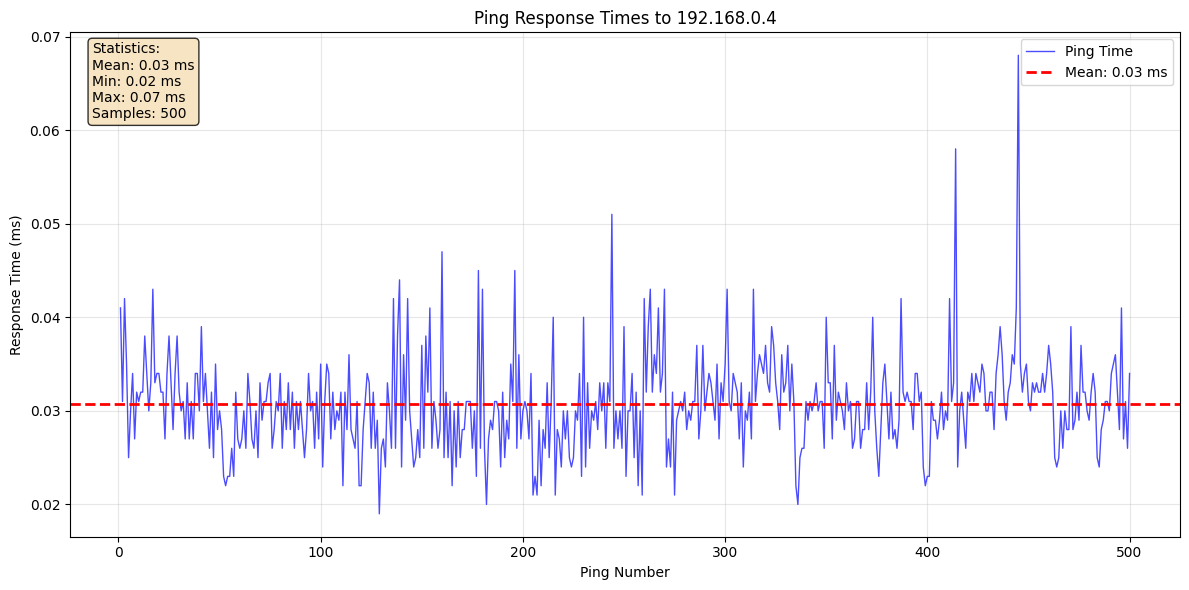


=== Ping Statistics for 192.168.0.4 ===
Total pings: 500
Mean response time: 0.03 ms
Minimum response time: 0.02 ms
Maximum response time: 0.07 ms


In [28]:
import sys
import matplotlib.pyplot as plt
import time

def ping_and_log(host, count): #Ping a host and collect response times
    times = []
    ping_count = 0
    
    print(f"Starting ping to {host}...")
    print(f"Collecting {count} data points...")
    
    try:
        while ping_count < count:
            try:
                # Run ping command
                result = send_cmd(['ping', '-c', '1', ip])
                
                if result.returncode == 0:
                    match = re.search(r'time=(\d+\.?\d*) ms', result.stdout)
                    
                    if match:
                        ping_time = float(match.group(1))
                        times.append(ping_time)
                        ping_count += 1
                        print(f"Ping {ping_count}: {ping_time} ms")
                    else:
                        print(f"Could not parse ping result: {result.stdout.strip()}")
                else:
                    print(f"Ping failed: {result.stderr.strip()}")
                    
            except subprocess.TimeoutExpired:
                print("Ping timeout")
            except Exception as e:
                print(f"Error during ping: {e}")
            
            # Small delay between pings
            time.sleep(0.1)
    
    except KeyboardInterrupt:
        print(f"\nInterrupted by user. Collected {len(times)} data points.")
    
    return times

def find_stats(dataset):
    mean_time = sum(dataset) / len(dataset)
    min_time = min(dataset)
    max_time = max(dataset)
    return mean_time, min_time, max_time
    
def plot_ping_data(times, host):
    """
    Plot ping times and display statistics
    """
    if not times:
        print("No data to plot!")
        return
    
    mean_time, min_time, max_time = find_stats(times)
    
    # Create the plot
    plt.figure(figsize=(12, 6))
    plt.plot(range(1, len(times) + 1), times, 'b-', linewidth=1, alpha=0.7, label='Ping Time')
    plt.axhline(y=mean_time, color='r', linestyle='--', linewidth=2, label=f'Mean: {mean_time:.2f} ms')
    
    plt.title(f'Ping Response Times to {host}')
    plt.xlabel('Ping Number')
    plt.ylabel('Response Time (ms)')
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    # Add statistics text box
    stats_text = f'Statistics:\nMean: {mean_time:.2f} ms\nMin: {min_time:.2f} ms\nMax: {max_time:.2f} ms\nSamples: {len(times)}'
    plt.text(0.02, 0.98, stats_text, transform=plt.gca().transAxes, 
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print(f"\n=== Ping Statistics for {host} ===")
    print(f"Total pings: {len(times)}")
    print(f"Mean response time: {mean_time:.2f} ms")
    print(f"Minimum response time: {min_time:.2f} ms")
    print(f"Maximum response time: {max_time:.2f} ms")

def main():
    target_count = 500
    print("Ping Logger and Plotter")
    print("=" * 30)
    
    # Collect ping data
    ping_times = ping_and_log(ip, target_count)
    
    if ping_times:
        # Plot the results
        plot_ping_data(ping_times, ip)
    else:
        print("No ping data collected!")

if __name__ == "__main__":
    main()

## 3. Signal Strength
iw dev wlp0s20f3 info

Signal strength logger
Signal 1: RX: 6.0 Mbps, TX: 245.0 Mbps, Signal: -36 dBm
Signal 2: RX: 6.0 Mbps, TX: 245.0 Mbps, Signal: -36 dBm
Signal 3: RX: 6.0 Mbps, TX: 245.0 Mbps, Signal: -36 dBm
Signal 4: RX: 6.0 Mbps, TX: 245.0 Mbps, Signal: -36 dBm
Signal 5: RX: 6.0 Mbps, TX: 245.0 Mbps, Signal: -36 dBm
Signal 6: RX: 573.5 Mbps, TX: 245.0 Mbps, Signal: -39 dBm
Signal 7: RX: 573.5 Mbps, TX: 245.0 Mbps, Signal: -39 dBm
Signal 8: RX: 573.5 Mbps, TX: 245.0 Mbps, Signal: -39 dBm
Signal 9: RX: 573.5 Mbps, TX: 245.0 Mbps, Signal: -39 dBm
Signal 10: RX: 573.5 Mbps, TX: 245.0 Mbps, Signal: -39 dBm
Signal 11: RX: 573.5 Mbps, TX: 245.0 Mbps, Signal: -39 dBm
Signal 12: RX: 573.5 Mbps, TX: 245.0 Mbps, Signal: -39 dBm
Signal 13: RX: 573.5 Mbps, TX: 245.0 Mbps, Signal: -39 dBm
Signal 14: RX: 573.5 Mbps, TX: 245.0 Mbps, Signal: -39 dBm
Signal 15: RX: 573.5 Mbps, TX: 245.0 Mbps, Signal: -39 dBm
Signal 16: RX: 573.5 Mbps, TX: 245.0 Mbps, Signal: -39 dBm
Signal 17: RX: 573.5 Mbps, TX: 245.0 Mbps, Signal: -

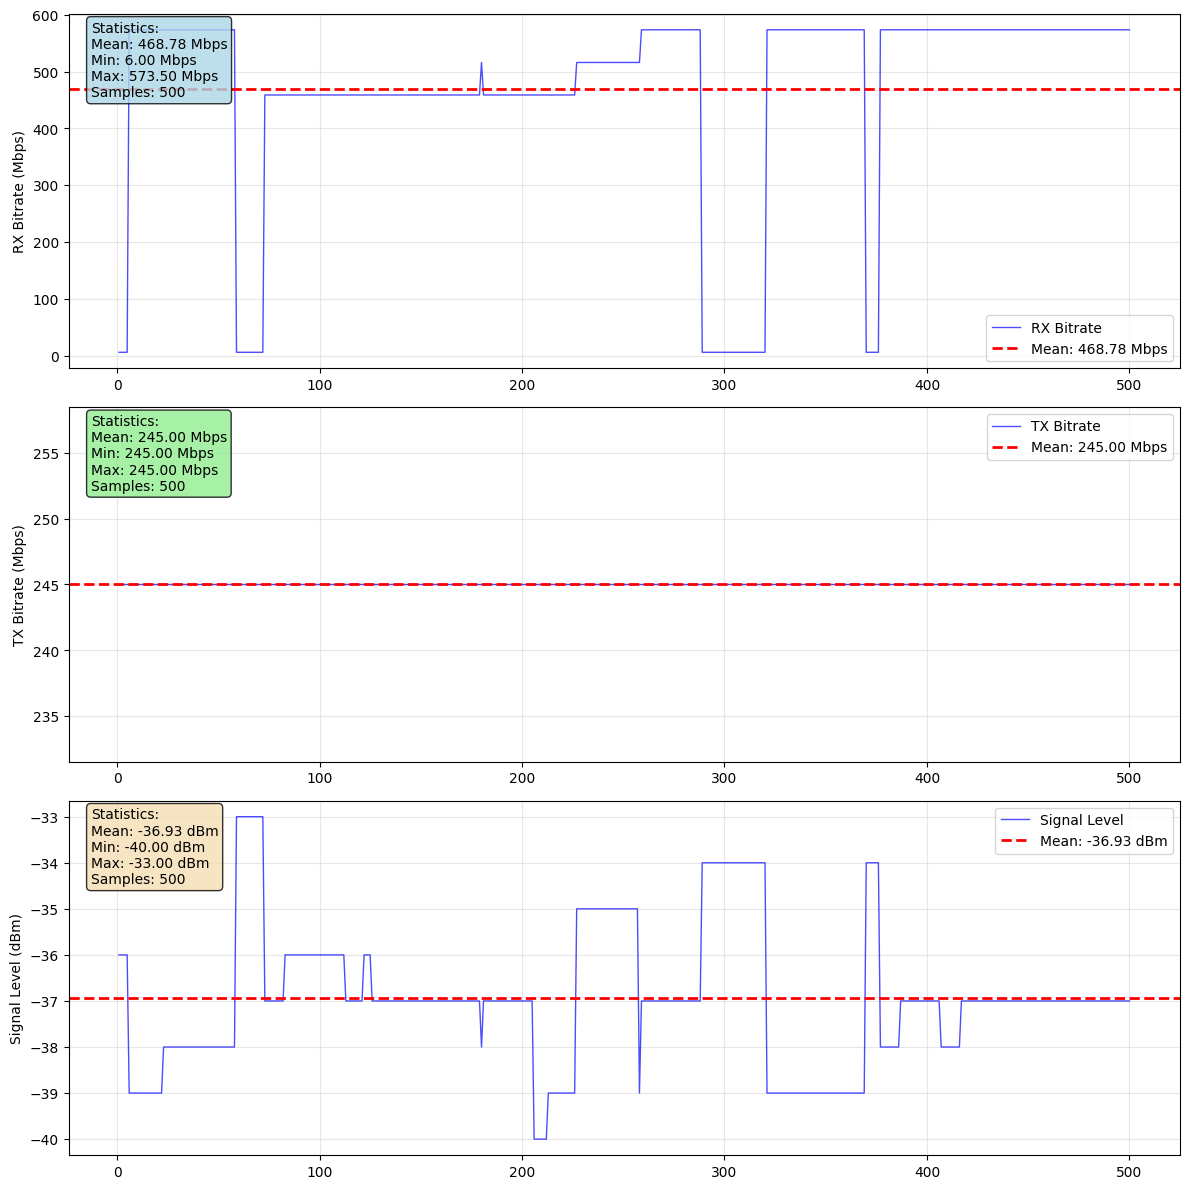


=== Signal Statistics for 192.168.0.4 ===
Total measurements: 500
Mean RX bitrate: 468.78 Mbps
Minimum RX bitrate: 6.00 Mbps
Maximum RX bitrate: 573.50 Mbps
Mean TX bitrate: 245.00 Mbps
Minimum TX bitrate: 245.00 Mbps
Maximum TX bitrate: 245.00 Mbps
Mean signal strength: -36.93 dBm
Minimum signal strength: -40.00 dBm
Maximum signal strength: -33.00 dBm


In [26]:
def info_logger(host, count):
    rx_bitrate_data = []
    tx_bitrate_data = []
    signal_data = []
    run_count = 0
    
    print("Collecting {count} points of signal data...")

    try:
        while run_count < count:
            try:
                # Run iw command
                result = send_cmd(['iw', 'dev', host, 'link'])
                
                if result.returncode == 0:
                    rx_bitrate_match = re.search(r'rx bitrate: (\d+\.?\d*) MBit/s', result.stdout)
                    tx_bitrate_match = re.search(r'tx bitrate: (\d+\.?\d*) MBit/s', result.stdout)
                    signal_match = re.search(r'signal: (-?\d+) dBm', result.stdout)
                    
                    if rx_bitrate_match and tx_bitrate_match and signal_match:
                        rx_bitrate = float(rx_bitrate_match.group(1))
                        tx_bitrate = float(tx_bitrate_match.group(1))
                        signal_level = int(signal_match.group(1))
                        rx_bitrate_data.append(rx_bitrate)
                        tx_bitrate_data.append(tx_bitrate)
                        signal_data.append(signal_level)
                        run_count += 1
                        print(f"Signal {run_count}: RX: {rx_bitrate} Mbps, TX: {tx_bitrate} Mbps, Signal: {signal_level} dBm")
                    else:
                        print(f"Could not parse result: {result.stdout.strip()}")
                else:
                    print(f"Measurement failed: {result.stderr.strip()}")
                    
            except subprocess.TimeoutExpired:
                print("Session timeout")
            except Exception as e:
                print(f"Error during data collection: {e}")
            
            # Small delay between measurements
            time.sleep(0.1)
    
    except KeyboardInterrupt:    
        print(f"\nInterrupted by user. Collected {len(signal_data)} data points.")
    
    return rx_bitrate_data, tx_bitrate_data, signal_data

def plot_info(rx_bitrate_data, tx_bitrate_data, signal_data, host):
    if not signal_data:
        print("No data to plot!")
        return
    
    mean_rx, min_rx, max_rx = find_stats(rx_bitrate_data)
    mean_tx, min_tx, max_tx = find_stats(tx_bitrate_data)
    mean_signal, min_signal, max_signal = find_stats(signal_data)

    fig,(ax1,ax2,ax3) = plt.subplots(3,1,figsize=(12, 12))
    ax1.plot(range(1, len(rx_bitrate_data) + 1), rx_bitrate_data, 'b-', linewidth=1, alpha=0.7, label='RX Bitrate')
    ax1.axhline(y=mean_rx, color='r', linestyle='--', linewidth=2, label=f'Mean: {mean_rx:.2f} Mbps')
    ax1.set_ylabel('RX Bitrate (Mbps)')
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    rx_stats_text = f'Statistics:\nMean: {mean_rx:.2f} Mbps\nMin: {min_rx:.2f} Mbps\nMax: {max_rx:.2f} Mbps\nSamples: {len(rx_bitrate_data)}'
    ax1.text(0.02, 0.98, rx_stats_text, transform=ax1.transAxes, 
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))

    ax2.plot(range(1, len(tx_bitrate_data) + 1), tx_bitrate_data, 'b-', linewidth=1, alpha=0.7, label='TX Bitrate')
    ax2.axhline(y=mean_tx, color='r', linestyle='--', linewidth=2, label=f'Mean: {mean_tx:.2f} Mbps')    
    ax2.set_ylabel('TX Bitrate (Mbps)')
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    tx_stats_text = f'Statistics:\nMean: {mean_tx:.2f} Mbps\nMin: {min_tx:.2f} Mbps\nMax: {max_tx:.2f} Mbps\nSamples: {len(tx_bitrate_data)}'
    ax2.text(0.02, 0.98, tx_stats_text, transform=ax2.transAxes, 
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8))
    

    ax3.plot(range(1, len(signal_data) + 1), signal_data, 'b-', linewidth=1, alpha=0.7, label='Signal Level')
    ax3.axhline(y=mean_signal, color='r', linestyle='--', linewidth=2, label=f'Mean: {mean_signal:.2f} dBm')
    ax3.set_ylabel('Signal Level (dBm)')
    ax3.grid(True, alpha=0.3)
    ax3.legend()
    signal_stats_text = f'Statistics:\nMean: {mean_signal:.2f} dBm\nMin: {min_signal:.2f} dBm\nMax: {max_signal:.2f} dBm\nSamples: {len(signal_data)}'
    ax3.text(0.02, 0.98, signal_stats_text, transform=ax3.transAxes, 
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

    plt.tight_layout()
    plt.show()

    print(f"\n=== Signal Statistics for {host} ===")    
    print(f"Total measurements: {len(signal_data)}")
    print(f"Mean RX bitrate: {mean_rx:.2f} Mbps")
    print(f"Minimum RX bitrate: {min_rx:.2f} Mbps")
    print(f"Maximum RX bitrate: {max_rx:.2f} Mbps")
    print(f"Mean TX bitrate: {mean_tx:.2f} Mbps")
    print(f"Minimum TX bitrate: {min_tx:.2f} Mbps")
    print(f"Maximum TX bitrate: {max_tx:.2f} Mbps")
    print(f"Mean signal strength: {mean_signal:.2f} dBm")
    print(f"Minimum signal strength: {min_signal:.2f} dBm")
    print(f"Maximum signal strength: {max_signal:.2f} dBm")


def main():
    target_count = 500
    
    print("Signal strength logger")
    print("=" * 30)
    
    rx_bitrate, tx_bitrate, signal_strength = info_logger(interface, target_count)
    if info_logger: 
        plot_info(rx_bitrate, tx_bitrate, signal_strength,ip)
    else:
        print("No info data collected!")

if __name__ == "__main__":
    main()        

## 4. Frequency and Tx Power
Command: iw dev wlp0s20f3 link

Logging link data for interface wlp0s20f3 - 500 points
Debug - Command output:
Interface wlp0s20f3
	ifindex 3
	wdev 0x1
	addr c4:03:a8:bd:56:a0
	ssid unifi-5G
	type managed
	wiphy 0
	channel 153 (5765 MHz), width: 80 MHz, center1: 5775 MHz
	txpower 22.00 dBm
	multicast TXQ:
		qsz-byt	qsz-pkt	flows	drops	marks	overlmt	hashcol	tx-bytes	tx-packets
		0	0	0	0	0	0	0	0		0


Link 1: SSID: unifi-5G, Address: c4:03:a8:bd:56:a0, Channel: 153, Frequency: 5765 MHz, Width: 80 MHz, Center: 5775 MHz, TX Power: 22.0 dBm
Link 2: SSID: unifi-5G, Address: c4:03:a8:bd:56:a0, Channel: 153, Frequency: 5765 MHz, Width: 80 MHz, Center: 5775 MHz, TX Power: 22.0 dBm
Link 3: SSID: unifi-5G, Address: c4:03:a8:bd:56:a0, Channel: 153, Frequency: 5765 MHz, Width: 80 MHz, Center: 5775 MHz, TX Power: 22.0 dBm
Link 4: SSID: unifi-5G, Address: c4:03:a8:bd:56:a0, Channel: 153, Frequency: 5765 MHz, Width: 80 MHz, Center: 5775 MHz, TX Power: 22.0 dBm
Link 5: SSID: unifi-5G, Address: c4:03:a8:bd:56:a0, Channel: 153, Frequenc

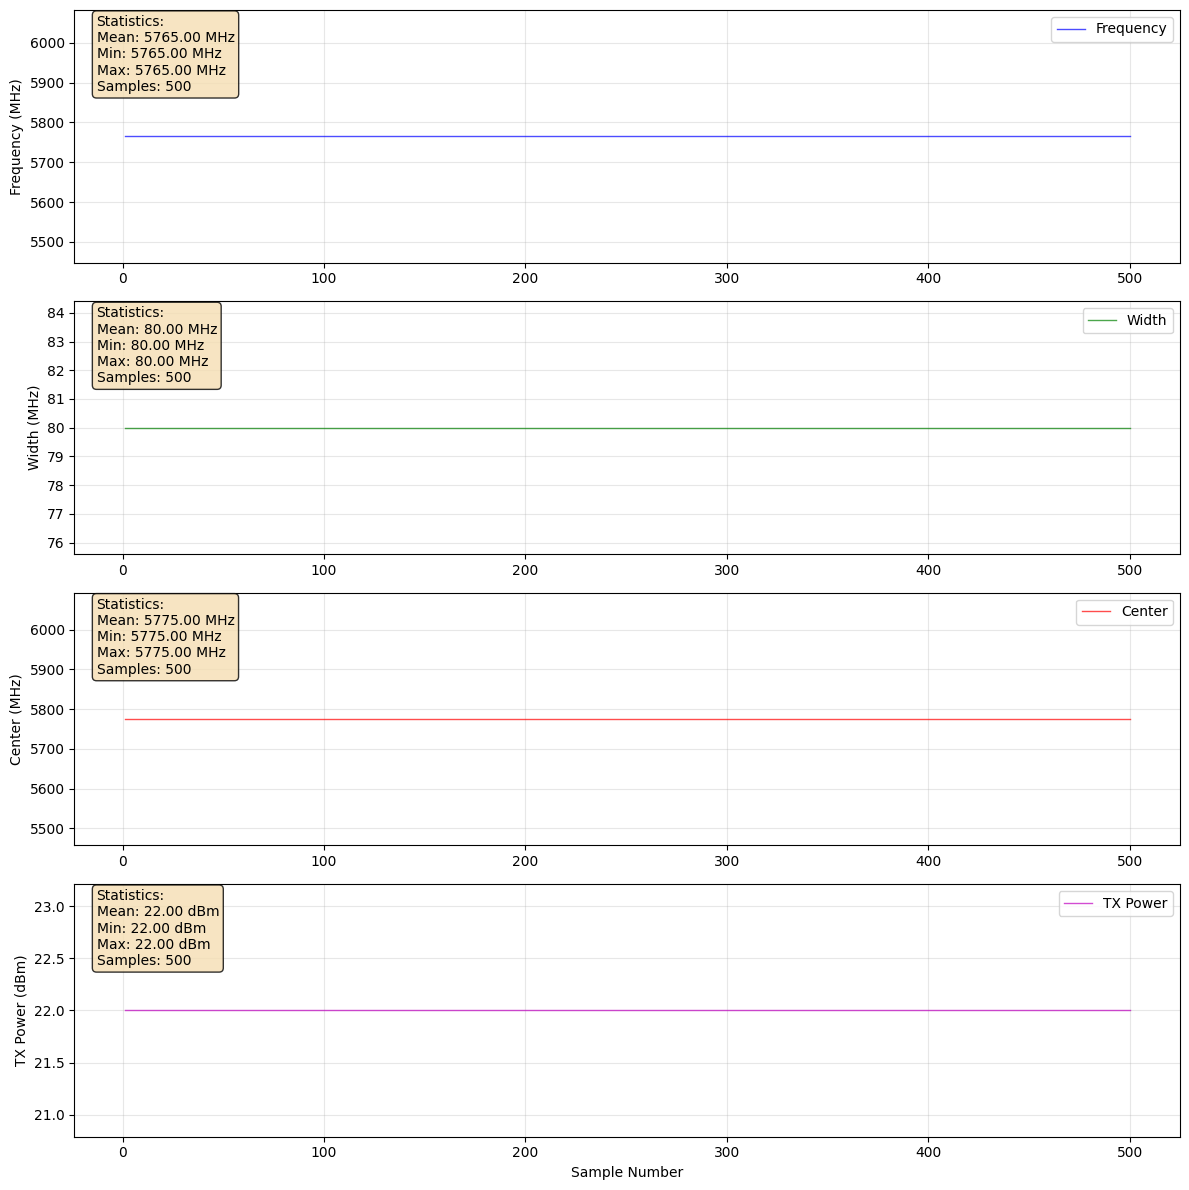


=== Link Statistics for wlp0s20f3 ===
Total measurements: 500
Mean frequency: 5765.00 MHz
Minimum frequency: 5765.00 MHz
Maximum frequency: 5765.00 MHz
Mean width: 80.00 MHz
Minimum width: 80.00 MHz
Maximum width: 80.00 MHz
Mean center: 5775.00 MHz
Minimum center: 5775.00 MHz
Maximum center: 5775.00 MHz
Mean TX power: 22.00 dBm
Minimum TX power: 22.00 dBm
Maximum TX power: 22.00 dBm


In [27]:
import subprocess
import re
import matplotlib.pyplot as plt

def send_cmd(cmd):
    """Execute a command and return the result"""
    try:
        result = subprocess.run(cmd, capture_output=True, text=True, timeout=10)
        return result
    except subprocess.TimeoutExpired:
        raise
    except Exception as e:
        raise Exception(f"Command execution failed: {e}")

def find_stats(data):
    """Calculate mean, min, max for a dataset"""
    if not data:
        return 0, 0, 0
    return sum(data) / len(data), min(data), max(data)

def link_logger(host, count):
    channel_data = []
    frequency_data = []
    width_data = []
    center_data = []
    tx_power_data = []
    run_count = 0

    print(f"Collecting {count} points of link data...")

    try:
        while run_count < count:
            result = send_cmd(['iw', 'dev', host, 'info'])
            
            # Debug: print the output to see what we're parsing
            if run_count == 0:  # Only print first iteration for debugging
                print(f"Debug - Command output:\n{result.stdout}\n")
            
            ssid_match = re.search(r'ssid (.+)', result.stdout)
            addr_match = re.search(r'addr ([a-fA-F0-9:]+)', result.stdout)
            # Fixed regex: txpower comes with decimal values like "17.00 dBm"
            channel_match = re.search(r'channel (\d+) \((\d+) MHz\), width: (\d+) MHz, center1: (\d+) MHz', result.stdout)
            txpower_match = re.search(r'txpower ([\d.]+) dBm', result.stdout)

            if ssid_match and addr_match and channel_match and txpower_match:
                ssid = ssid_match.group(1).strip()
                addr = addr_match.group(1).strip()
                channel = int(channel_match.group(1))
                frequency = int(channel_match.group(2))
                width = int(channel_match.group(3))
                center = int(channel_match.group(4))
                # Fixed: txpower_match.group(1), not group(5)
                tx_power = float(txpower_match.group(1))
                
                channel_data.append(channel)
                frequency_data.append(frequency)
                width_data.append(width)
                center_data.append(center)
                tx_power_data.append(tx_power)
                run_count += 1
                
                # Fixed: print individual values, not the entire list
                print(f"Link {run_count}: SSID: {ssid}, Address: {addr}, Channel: {channel}, Frequency: {frequency} MHz, Width: {width} MHz, Center: {center} MHz, TX Power: {tx_power} dBm")
            else:
                print(f"Could not parse result: {result.stdout.strip()}")
                # Debug: show which matches failed
                print(f"  SSID match: {ssid_match is not None}")
                print(f"  Addr match: {addr_match is not None}")
                print(f"  Channel match: {channel_match is not None}")
                print(f"  TX Power match: {txpower_match is not None}")
            time.sleep(0.1)
    except subprocess.TimeoutExpired:
        print("Session timeout")
    except Exception as e:
        print(f"Error during data collection: {e}")
    
    return frequency_data, width_data, center_data, tx_power_data


def plot_link(host, frequency_data, width_data, center_data, tx_power_data):

    if not frequency_data or not width_data or not center_data or not tx_power_data:
        print("No data to plot!")
        return
    
    mean_frequency, min_frequency, max_frequency = find_stats(frequency_data)
    mean_width, min_width, max_width = find_stats(width_data)
    mean_center, min_center, max_center = find_stats(center_data)
    mean_tx_power, min_tx_power, max_tx_power = find_stats(tx_power_data)

    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 12))
    
    ax1.plot(range(1, len(frequency_data) + 1), frequency_data, 'b-', linewidth=1, alpha=0.7, label='Frequency')
    ax1.set_ylabel('Frequency (MHz)')
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    frequency_stats_text = f'Statistics:\nMean: {mean_frequency:.2f} MHz\nMin: {min_frequency:.2f} MHz\nMax: {max_frequency:.2f} MHz\nSamples: {len(frequency_data)}'
    ax1.text(0.02, 0.98, frequency_stats_text, transform=ax1.transAxes, 
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

    ax2.plot(range(1, len(width_data) + 1), width_data, 'g-', linewidth=1, alpha=0.7, label='Width')
    ax2.set_ylabel('Width (MHz)')
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    width_stats_text = f'Statistics:\nMean: {mean_width:.2f} MHz\nMin: {min_width:.2f} MHz\nMax: {max_width:.2f} MHz\nSamples: {len(width_data)}'
    ax2.text(0.02, 0.98, width_stats_text, transform=ax2.transAxes, 
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

    ax3.plot(range(1, len(center_data) + 1), center_data, 'r-', linewidth=1, alpha=0.7, label='Center')
    ax3.set_ylabel('Center (MHz)')
    ax3.grid(True, alpha=0.3)
    ax3.legend()
    center_stats_text = f'Statistics:\nMean: {mean_center:.2f} MHz\nMin: {min_center:.2f} MHz\nMax: {max_center:.2f} MHz\nSamples: {len(center_data)}'
    ax3.text(0.02, 0.98, center_stats_text, transform=ax3.transAxes, 
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

    ax4.plot(range(1, len(tx_power_data) + 1), tx_power_data, 'm-', linewidth=1, alpha=0.7, label='TX Power')
    ax4.set_ylabel('TX Power (dBm)')
    ax4.set_xlabel('Sample Number')
    ax4.grid(True, alpha=0.3)
    ax4.legend()
    tx_power_stats_text = f'Statistics:\nMean: {mean_tx_power:.2f} dBm\nMin: {min_tx_power:.2f} dBm\nMax: {max_tx_power:.2f} dBm\nSamples: {len(tx_power_data)}'
    ax4.text(0.02, 0.98, tx_power_stats_text, transform=ax4.transAxes, 
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

    plt.tight_layout()
    plt.show()

    print(f"\n=== Link Statistics for {host} ===")
    print(f"Total measurements: {len(frequency_data)}")
    print(f"Mean frequency: {mean_frequency:.2f} MHz")
    print(f"Minimum frequency: {min_frequency:.2f} MHz")
    print(f"Maximum frequency: {max_frequency:.2f} MHz")
    print(f"Mean width: {mean_width:.2f} MHz")
    print(f"Minimum width: {min_width:.2f} MHz")
    print(f"Maximum width: {max_width:.2f} MHz")
    print(f"Mean center: {mean_center:.2f} MHz")
    print(f"Minimum center: {min_center:.2f} MHz")
    print(f"Maximum center: {max_center:.2f} MHz")
    print(f"Mean TX power: {mean_tx_power:.2f} dBm")
    print(f"Minimum TX power: {min_tx_power:.2f} dBm")
    print(f"Maximum TX power: {max_tx_power:.2f} dBm")

def main():
    # Set your interface name here
    interface = "wlp0s20f3"  # Based on your output
    target_count = 500

    print(f"Logging link data for interface {interface} - {target_count} points")
    print("=" * 50)

    frequency_data, width_data, center_data, tx_power_data = link_logger(interface, target_count)
    
    # Fixed: check if we have data, not if function exists
    if frequency_data:  # Check if we got any data
        plot_link(interface, frequency_data, width_data, center_data, tx_power_data)
    else:
        print("No link data collected!")

if __name__ == "__main__":
    main()